<a href="https://colab.research.google.com/github/dit21dsc/Image-coloring/blob/main/%20Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image 
from tensorflow.keras.utils  import array_to_img, img_to_array, load_img
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape,  concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
#OPTIMIZER
from tensorflow.keras.optimizers import RMSprop,Adam,Optimizer,Optimizer, SGD

In [3]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D,\
ZeroPadding2D, Convolution2D, ZeroPadding2D, Conv2DTranspose,ReLU, UpSampling2D, Concatenate, Conv2DTranspose

In [4]:
Gray_NPY = np.load("/content/drive/MyDrive/gray_scale.npy")
AB_1_NPY = np.load("/content/drive/MyDrive/ab1.npy")

In [5]:
print(type(Gray_NPY))
print(type(AB_1_NPY))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [7]:
print(Gray_NPY.shape)
print(AB_1_NPY.shape)

(25000, 224, 224)
(10000, 224, 224, 2)


In [8]:
splitting_count = 300
end_splitting_count = 600

In [9]:
X_Train = Gray_NPY[:splitting_count,:,:].astype("float32").reshape(splitting_count,
                                                                  Gray_NPY.shape[1],
                                                                   Gray_NPY.shape[2])

In [10]:
X_Non_Seen = Gray_NPY[splitting_count:end_splitting_count,:,:].astype("float32").reshape(splitting_count,
                                                                  Gray_NPY.shape[1],
                                                                   Gray_NPY.shape[2])

In [11]:
Y_Train = AB_1_NPY[:splitting_count,:,:].astype("float32")

In [12]:
print(X_Train.shape)
print(X_Non_Seen.shape)
print(Y_Train.shape)

(300, 224, 224)
(300, 224, 224)
(300, 224, 224, 2)


In [13]:
def line_image(gray_images,splitting_count=splitting_count,preprocess_function=preprocess_input):
    Zeros_Imp = np.zeros((splitting_count,224,224,3))
    for indexing in range(0,3):
        Zeros_Imp[:splitting_count,:,:,indexing] = gray_images[:splitting_count]
        
    return preprocess_function(Zeros_Imp)

In [14]:
Input_Images = line_image(X_Train,splitting_count)

Non_Seen_Input = line_image(X_Non_Seen,splitting_count)



In [15]:
print(Input_Images.shape)
print(Non_Seen_Input.shape)

(300, 224, 224, 3)
(300, 224, 224, 3)


In [16]:
def from_lab_to_rgb(gray_images,ab_images,n=10):
    Zeros_Imp = np.zeros((n,224,224,3))
    
    Zeros_Imp[:,:,:,0] = gray_images[0:n:]
    Zeros_Imp[:,:,:,1:] = ab_images[0:n:]
    
    Zeros_Imp = Zeros_Imp.astype("uint8")
    
    Main_Img = []
    
    for indexing in range(0,n):
        Main_Img.append(cv2.cvtColor(Zeros_Imp[indexing],cv2.COLOR_LAB2RGB))
        
    Main_Img = np.array(Main_Img)
    
    return Main_Img

In [17]:
Output_Images = preprocess_input(from_lab_to_rgb(X_Train,Y_Train,n=splitting_count))

print(Output_Images.shape)

(300, 224, 224, 3)


In [18]:
Gray_Zeros_Imp = np.zeros((splitting_count,Gray_NPY.shape[1],Gray_NPY.shape[2],1))
Gray_Zeros_Imp[:,:,:,0] = X_Train
print(Gray_Zeros_Imp.shape)

(300, 224, 224, 1)


In [19]:
compile_loss = "mse"
compile_optimizer = RMSprop(learning_rate=0.0001,decay=1e-8)
compile_metrics = ["accuracy"]
input_dim = (Input_Images.shape[1],Input_Images.shape[2],Input_Images.shape[3])
output_class = 1

In [20]:
Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      filepath="./modelcheck")

In [21]:
Encoder_G = Sequential()
Encoder_G.add(Conv2D(32,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Encoder_G.add(BatchNormalization())
Encoder_G.add(ReLU())

In [22]:
Encoder_G.add(Conv2D(64,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Encoder_G.add(BatchNormalization())
Encoder_G.add(ReLU())
#

In [23]:
Encoder_G.add(Conv2D(128,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Encoder_G.add(BatchNormalization())
Encoder_G.add(ReLU())


In [24]:

Encoder_G.add(Conv2D(256,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Encoder_G.add(BatchNormalization())
Encoder_G.add(ReLU())

In [25]:
Decoder_G = Sequential()
Decoder_G.add(Conv2DTranspose(128,(2,2),padding = "same",use_bias = True))
Decoder_G.add(ReLU())
#

In [26]:
Decoder_G.add(Conv2DTranspose(64,(2,2),padding = "same",use_bias = True))
Decoder_G.add(ReLU())
#

In [27]:
Decoder_G.add(Conv2DTranspose(32,(2,2),padding = "same",use_bias = True))
Decoder_G.add(ReLU())
#

In [28]:
Decoder_G.add(Conv2DTranspose(3,(2,2),padding = "same",use_bias = True))
Decoder_G.add(ReLU())

In [29]:
Auto_Encoder = Sequential([Encoder_G,Decoder_G])
Auto_Encoder.compile(loss=compile_loss,optimizer=compile_optimizer,metrics=compile_metrics)
Auto_Encoder_Model = Auto_Encoder.fit(Input_Images,Output_Images,epochs=25,callbacks=[Early_Stopper,Checkpoint_Model],batch_size=16)

Epoch 1/25
19/19 [==============================] - 655s 34s/step - loss: 0.3820 - accuracy: 0.5168
Epoch 2/25
19/19 [==============================] - 633s 33s/step - loss: 0.3562 - accuracy: 0.5562
Epoch 3/25
19/19 [==============================] - 629s 33s/step - loss: 0.3389 - accuracy: 0.5490
Epoch 4/25
19/19 [==============================] - 633s 33s/step - loss: 0.3347 - accuracy: 0.5504
Epoch 5/25
19/19 [==============================] - 636s 34s/step - loss: 0.3331 - accuracy: 0.5526
Epoch 6/25
19/19 [==============================] - 632s 33s/step - loss: 0.3330 - accuracy: 0.5600
Epoch 7/25
19/19 [==============================] - 630s 33s/step - loss: 0.3313 - accuracy: 0.5602
Epoch 8/25
19/19 [==============================] - 644s 34s/step - loss: 0.3334 - accuracy: 0.5622
Epoch 9/25
19/19 [==============================] - 636s 33s/step - loss: 0.3320 - accuracy: 0.5635
Epoch 10/25
19/19 [==============================] - 631s 33s/step - loss: 0.3329 - accuracy: 0.5577

In [30]:
#PREDICTION

Prediction_IMG = Auto_Encoder.predict(Input_Images[:30])

Prediction_Non_Seen = Auto_Encoder.predict(Non_Seen_Input[:30])

print(Prediction_IMG[20].shape)
print(Prediction_Non_Seen[20].shape)

(224, 224, 3)
(224, 224, 3)


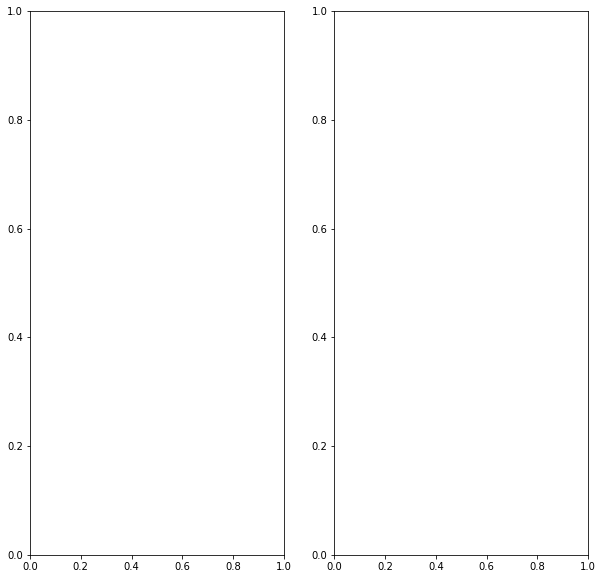

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')

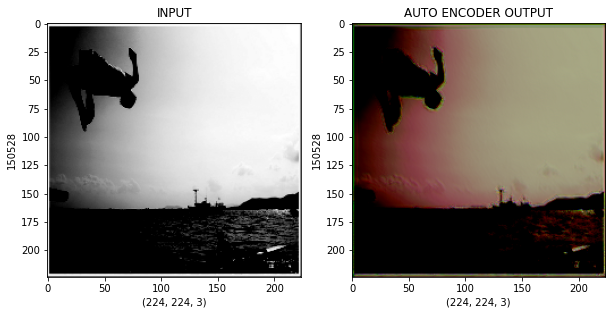

In [45]:
figure,axis = plt.subplots(1,2,figsize=(10,10))
prediction_img_number = 3

Original_Img = Input_Images[prediction_img_number]
Predict_Image_AE = Prediction_IMG[prediction_img_number]
axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("INPUT")
axis[1].imshow(Predict_Image_AE)
axis[1].set_xlabel(Predict_Image_AE.shape)
axis[1].set_ylabel(Predict_Image_AE.size)
axis[1].set_title("AUTO ENCODER OUTPUT")

#Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')

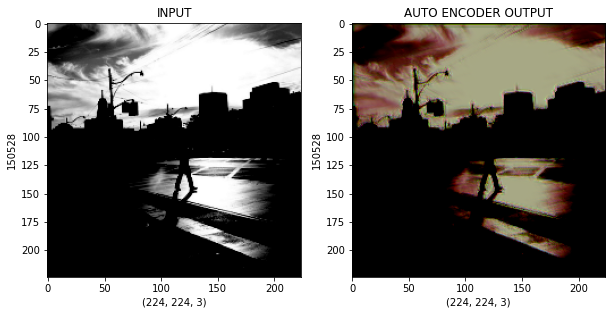

In [37]:
figure,axis = plt.subplots(1,2,figsize=(10,10))
prediction_img_number = 10

Original_Img = Input_Images[prediction_img_number]
Predict_Image_AE = Prediction_IMG[prediction_img_number]

axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("INPUT")
axis[1].imshow(Predict_Image_AE)
axis[1].set_xlabel(Predict_Image_AE.shape)
axis[1].set_ylabel(Predict_Image_AE.size)
axis[1].set_title("AUTO ENCODER OUTPUT")

#Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')

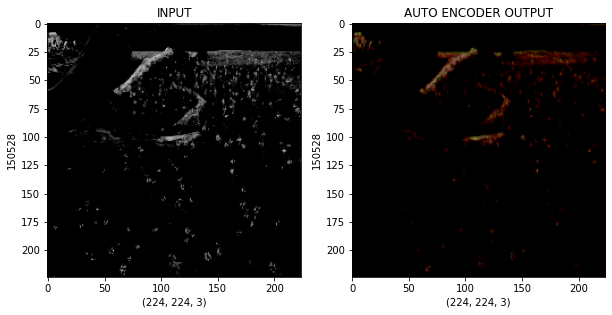

In [39]:
figure,axis = plt.subplots(1,2,figsize=(10,10))
prediction_img_number = 22

Original_Img = Input_Images[prediction_img_number]
Predict_Image_AE = Prediction_IMG[prediction_img_number]

axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("INPUT")
axis[1].imshow(Predict_Image_AE)
axis[1].set_xlabel(Predict_Image_AE.shape)
axis[1].set_ylabel(Predict_Image_AE.size)
axis[1].set_title("AUTO ENCODER OUTPUT")

#Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')

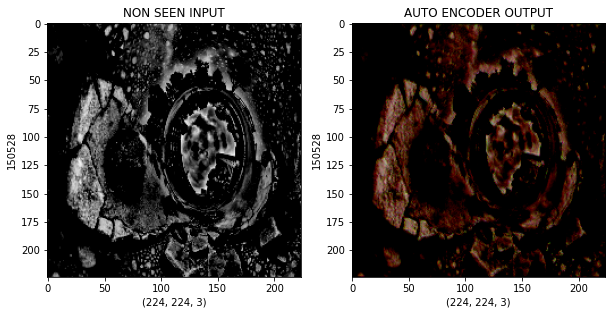

In [40]:
figure,axis = plt.subplots(1,2,figsize=(10,10))
prediction_img_number = 2

Original_Img = Non_Seen_Input[prediction_img_number]
Predict_Image_AE = Prediction_Non_Seen[prediction_img_number]

axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("NON SEEN INPUT")
axis[1].imshow(Predict_Image_AE)
axis[1].set_xlabel(Predict_Image_AE.shape)
axis[1].set_ylabel(Predict_Image_AE.size)
axis[1].set_title("AUTO ENCODER OUTPUT")

#Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')

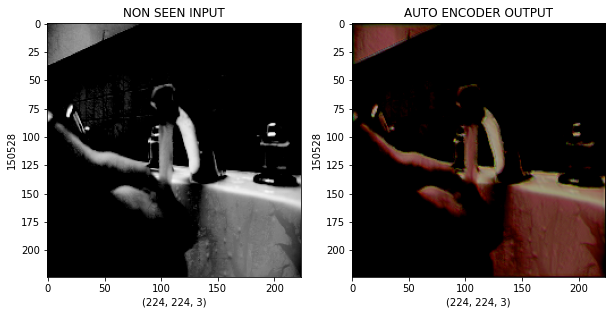

In [41]:
figure,axis = plt.subplots(1,2,figsize=(10,10))
prediction_img_number = 13

Original_Img = Non_Seen_Input[prediction_img_number]
Predict_Image_AE = Prediction_Non_Seen[prediction_img_number]

axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("NON SEEN INPUT")
axis[1].imshow(Predict_Image_AE)
axis[1].set_xlabel(Predict_Image_AE.shape)
axis[1].set_ylabel(Predict_Image_AE.size)
axis[1].set_title("AUTO ENCODER OUTPUT")

#Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')

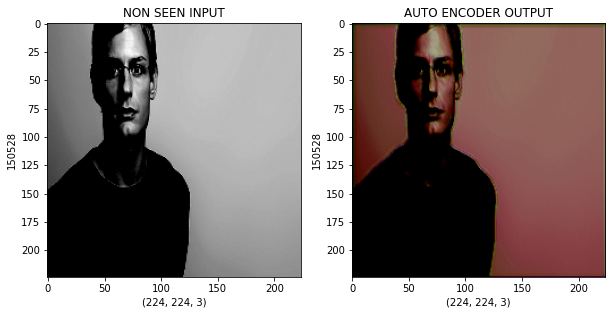

In [42]:
figure,axis = plt.subplots(1,2,figsize=(10,10))
prediction_img_number = 29

Original_Img = Non_Seen_Input[prediction_img_number]
Predict_Image_AE = Prediction_Non_Seen[prediction_img_number]

axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("NON SEEN INPUT")
axis[1].imshow(Predict_Image_AE)
axis[1].set_xlabel(Predict_Image_AE.shape)
axis[1].set_ylabel(Predict_Image_AE.size)
axis[1].set_title("AUTO ENCODER OUTPUT")

#Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')